This notebook will cover the SpikeInterface pipeline for extracellular analysis and spike sorting comparison. 

Spikeinterface wraps 5 subpackages: spikeextractors, spikesorters, spiketoolkit, spikecomparison, and spikewidgets.

For this analysis, we will use our 384-channel dataset from Neuropixels obtained during the 360 degrees paradigm experimentation with vestibular stimulation by rotation of the stage.

The summary of the pipeline is the following :

- load the data with spikeextractors package
- load the probe information using ProbeInterface
- preprocess the signals
- run 4 popular spike sorting algorithms with different parameters
- curate the spike sorting output using 1) quality metrics (automatic) - 2) Phy (manual) - 3) consensus-based

All these operations are executed in a new Python 3.7 Anaconda environment named "Spikeline" specifically created for the spike sorting purposes.


# Importing the modules

Let's now import the `spikeinterface` modules needed.

In [2]:



import os 
import spikeinterface
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display
from IPython import get_ipython
from varname import nameof
from scipy.ndimage.filters import gaussian_filter1d
plt.rcParams.update({'font.size': 14})



## Loading recording and probe information


In [3]:
# Add the path to the folder containing our recording's ap.bin file 

Path_to_folder_containing_data = r'F:\Data_recording\Lab_presentation\003WO.1_014_turning_different_speeds_g0_imec0'

Path = r'F:\Data_recording\003WO.1_014_PVT_2_103_g0_imec0'
# Function to read the file with the dedicated SpikeExtractor for the output of our recording software SpikeGLX, the function does a loop in case other recording folders exist but here we have only one analysis
def Read_file(Path_to_folder_containing_data):
    for fichier in os.listdir(Path_to_folder_containing_data):        
        if fichier.endswith('.imec0.ap.bin'):
            recording = se.SpikeGLXRecordingExtractor(file_path=os.path.join(Path_to_folder_containing_data,fichier))
            file_path = os.path.join(Path_to_folder_containing_data,fichier)
            return recording
        
recording = Read_file(Path_to_folder_containing_data)

## Visualizing the data before pre-processing it

SpikeWidgets is a package of the SpikeInterface project that was designed for visualization of various aspects of the spike sorting pipeline.

We look at the data before pre-processing stage



In [4]:


range1 = [*range(10,50)]
range2 = [*range(91,96)]
range3 = [*range(59,65)]
range4= [*range(165,171)]
#Visualizing the recording extractor object
w_ts = sw.plot_timeseries(recording, channel_ids=range4,  trange=[16,18])
plt.title('Recording traces')
plt.xlabel('Time(s)')
plt.ylabel('Voltage')

Text(0, 0.5, 'Voltage')

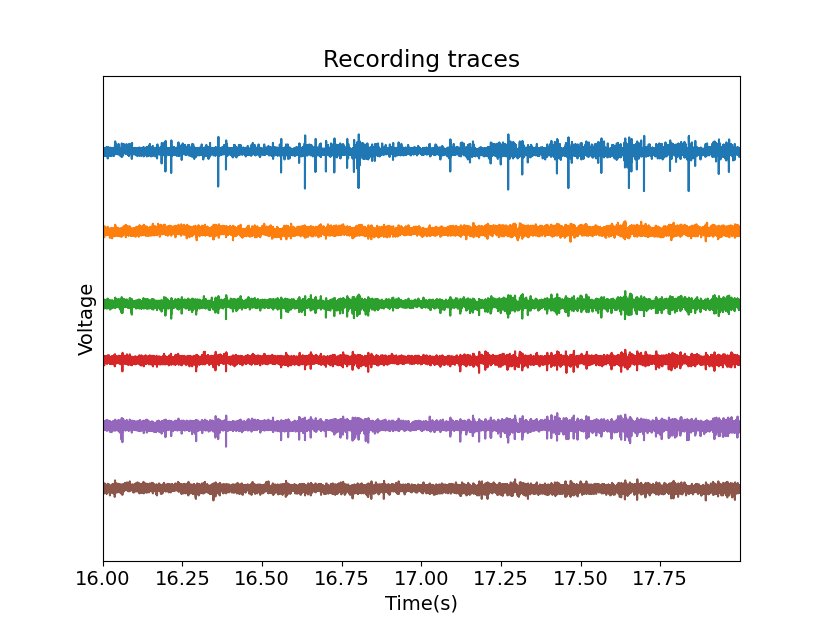

We can now pre-process uniformly the recording for the spikesorters through the Spike toolkit package.

In [4]:


def pre_processing(recording):
    #We remove the ground channel from the recording
    recording1 = st.preprocessing.remove_bad_channels(recording, bad_channel_ids=[191])
    #Filtering to separate them: high pass filtering for the spikes (generally set at 6000Hz) and 
    #low-pass filtering for the synaptic mechanisms (generally set at 300Hz).  
    recording2 = st.preprocessing.bandpass_filter(recording1, freq_min=300, freq_max=6000)
    #Whiten the signal
    recording3 = st.preprocessing.whiten(recording2)
    #Application of common median reference, the median of the selected channels is removed for each timestamp
    recording4 = st.preprocessing.common_reference(recording3, reference='median')
    return recording4


recording_preprocessed = pre_processing(recording=recording)



All operations in SpikeInterface are lazy, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. 

However, to speed up further processing, we might want to cache it to a file and perform the other operations.

If we now closed the Python session, we would have .dat file, but no information on how to open it! In order to save the state of an extractor, we can use the dumping mechanism. Each extractor can be converted to a dictionary, which holds the path to the data file and all relevant information:


In [16]:
def dump_to_pkl(recording,Path_to_folder_containing_data):
    recording_cache = se.CacheRecordingExtractor(recording, n_jobs=1, chunk_mb=500, verbose=True)
    recording_cache.filename
    recording_cache.get_tmp_folder()
    recording_cache.move_to(Path_to_folder_containing_data+'/dataall.dat') 
    recording_cache.dump_to_dict()
    pkl = Path_to_folder_containing_data+'/filtered_dataall_'+ os.path.basename(Path_to_folder_containing_data)+'.pkl'
    recording_cache.dump_to_pickle(pkl)
    return pkl

#dump_to_pkl(recording=recording_preprocessed,Path_to_folder_containing_data=Path_to_folder_containing_data)

#Loading the filtered data stored in pkl. In another session, we can pick up from where we left by 
#loading the extractor from the pickle file:
def load_recording(pkl_path):
    recording_loaded = se.load_extractor_from_pickle(pkl_path)
    return recording_loaded

pkl_path=Path_to_folder_containing_data+'/filtered_dataall_'+ os.path.basename(Path_to_folder_containing_data)+'.pkl'
recording_loaded = load_recording(pkl_path)

In [ ]:
#Pre-processed data loaded plot view

range4= [*range(165,171)]
w_ts = sw.plot_timeseries(recording_preprocessed, channel_ids=range4)
plt.title('Recording traces')
plt.xlabel('Time(s)')
plt.ylabel('Voltage')

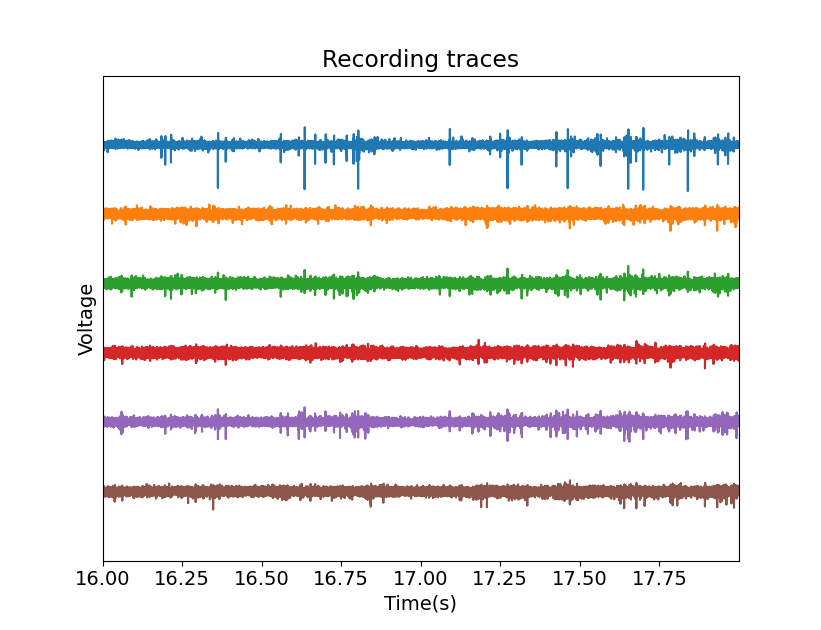



## Spike sorting


We can now proceed to the spike sorting on the above recording. We decided to use 4 sorters in the purpose of our analysis, HerdingSpikes, Ironclust, Kilosort2 and Tridesclous.




In [9]:

ss.available_sorters()
#We can retrieve the parameters associated to any sorter with the get_default_params() function from the spikesorters module:


#For MATLAB-based sorters - Ironclust and Kilosort2, we had to clone the sorter repo and point it to SpikeInterface
def Run_Kilosort(recording_loaded,Path_results):
    ss.Kilosort2Sorter.set_kilosort2_path(r'F:\Sorters\Kilosort2')
    Path_kilosort_results = os.path.join(Path_results,'_KS2_results')
    os.mkdir(Path_kilosort_results)
    sorting_KS2 = ss.run_kilosort2(recording_loaded, car = 'False', output_folder=Path_kilosort_results)
    return sorting_KS2, Path_kilosort_results

def Run_Tridesclous(recording_loaded,Path_results):
    Path_tridesclous_results = os.path.join(Path_results,'_TDC_results')
    os.mkdir(Path_tridesclous_results)
    sorting_TDC = ss.run_tridesclous(recording_loaded, detect_threshold = 6, output_folder=Path_tridesclous_results)
    return sorting_TDC, Path_tridesclous_results

def Run_Ironclust(recording_loaded,Path_results):
    ss.IronClustSorter.set_ironclust_path(r'F:\Sorters\ironclust')
    Path_ironclust_results = os.path.join(Path_results,'_Ironclust_results')
    os.mkdir(Path_ironclust_results)
    sorting_IC = ss.run_ironclust(recording_loaded, output_folder=Path_ironclust_results, detect_threshold = 6, pc_per_chan = 3, common_ref_type = 'none')
    return sorting_IC, Path_ironclust_results

def Run_Herdingspikes(recording_loaded,Path_results):
    Path_Herdingspikes_results = os.path.join(Path_results,'_Herdingspikes_results')
    os.mkdir(Path_Herdingspikes_results)
    sorting_Herdingspikes = ss.run_herdingspikes(recording_loaded, clustering_bandwidth =8,pca_ncomponents = 3, detect_threshold = 6, output_folder=Path_Herdingspikes_results)
    return sorting_Herdingspikes, Path_Herdingspikes_results


def Run_sorters(recording_loaded,Path_to_folder_containing_data):
    Path_results=os.path.join(Path_to_folder_containing_data,'Sorting_results')
    os.mkdir(Path_results)
    Sorters = []
    Pathsresults = []
    try :
        sorting_KS2, Path_kilosort_results = Run_Kilosort(recording_loaded,Path_results)
        Sorters.append(sorting_KS2)
        Pathsresults.append(Path_kilosort_results)
    finally:
           try :
                sorting_TDC, Path_tridesclous_results = Run_Tridesclous(recording_loaded=recording_loaded,Path_results=Path_results)
                Sorters.append(sorting_TDC)
                Pathsresults.append(Path_tridesclous_results)     
           finally:
                  try :
                      sorting_IC, Path_ironclust_results = Run_Ironclust(recording_loaded=recording_loaded,Path_results=Path_results)
                      Sorters.append(sorting_IC)
                      Pathsresults.append(Path_ironclust_results)
                  finally:
                         try :
                             sorting_Herdingspikes, Path_Herdingspikes_results = Run_Herdingspikes(recording_loaded=recording_loaded,Path_results=Path_results)
                             Sorters.append(sorting_Herdingspikes)
                             Pathsresults.append.append(Path_Herdingspikes_results)
                         finally : 
                             return Sorters, Pathsresults


To perform manual curation later we will export the data to Phy.

In [12]:

Path_results = r'F:\SO8002\Desktop\Data_presentation\003WO.1_007_PVTmanual_slowslow_g0_imec0\Sorting_results'

def Export_to_Phy(sorting, result_paths, recording_loaded):
    for i in range(0,len(sorting)):
        try :
            Path_phy_result = os.path.join(result_paths[i], 'Phy')
            st.postprocessing.export_to_phy(recording_loaded, 
                                    sorting[i], output_folder=Path_phy_result,verbose=True, recompute_info=True, n_jobs=1,max_channels_per_template=10)
        finally :
            pass

Path_kilosort_results= r'F:\Data_recording\Lab_presentation\003WO.1_014_turning_different_speeds_g0_imec0\Sorting_results\_KS2_results'
Path_tridesclous_results =r'F:\Data_recording\Lab_presentation\003WO.1_014_turning_different_speeds_g0_imec0\Sorting_results\_TDC_results'
Path_ironclust_results =r'F:\Data_recording\Lab_presentation\003WO.1_014_turning_different_speeds_g0_imec0\Sorting_results\_Ironclust_results\tmp\firings.mda'
Path_herdingspikes_results =r'F:\Data_recording\Lab_presentation\003WO.1_014_turning_different_speeds_g0_imec0\Sorting_results\_Herdingspikes_results\HS2_sorted.hdf5'

#The sorting extractors allow to reload easily the sorting results obtained
sorting_KS2 = se.KiloSortSortingExtractor(Path_kilosort_results)
sorting_TDC = se.TridesclousSortingExtractor(Path_tridesclous_results)
sorting_IC = se.MdaSortingExtractor(Path_ironclust_results)
sorting_HS2= se.HS2SortingExtractor(Path_herdingspikes_results)


Sorters=[sorting_KS2,sorting_TDC,sorting_IC,sorting_HS2]
Sorters_name = ['sorting_KS2','sorting_TDC','sorting_IC','sorting_HS2']


The spike sorting returns a SortingExtractor object. Let's see how many spikes were returned by the sorters.

In [13]:

print('Units KS2', len(sorting_KS2.get_unit_ids()))
print('Units TDC', len(sorting_TDC.get_unit_ids()))
print('Units IC', len(sorting_IC.get_unit_ids()))
print('Units HS2', len(sorting_HS2.get_unit_ids()))


Units KS2 143
Units TDC 39
Units IC 38
Units HS2 24


## Post-processing


The postprocessing submodule of spiketoolkit allow us to extract information from the combination of the recording 
and sorting extractors. For example, we can extract waveforms, templates, maximum channels and pca scores.

Extending this it can be seen that a raster plot displays the pattern of spikes across a neuron group over time.


In [14]:


w_rs = sw.plot_rasters(sorting_HS2, trange=[0,60])
plt.title('Raster plot')
plt.xlabel('Time(s)')
plt.ylabel('Unit id')



Text(0, 0.5, 'Unit id')

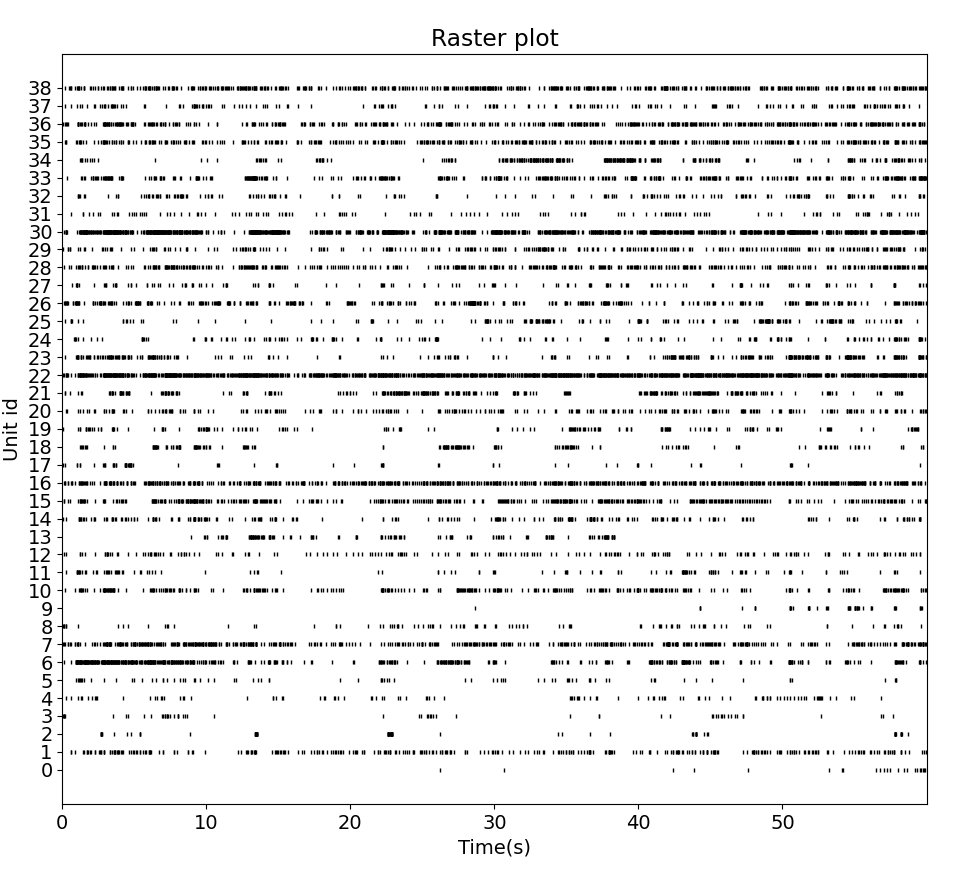

In [21]:

#We can see that the unit 22 presents a lot of activity along time, we can take a further look at it by looking at
#the waveforms and templates extracted
#Each waveform is associated with a specific spike, so they are saved as spike features

#300 waveforms were extracted from the 1702 spike train of the first unit.

waveforms = st.postprocessing.get_unit_waveforms(recording_loaded, sorting_TDC)

print(waveforms[22].shape)
print(len(sorting_TDC.get_unit_spike_train(22)))



(300, 383, 180)
1702


## Extra-cellular features



Extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes. The postprocessing module of spiketoolkit allows one to compute several of these features:
These consist of a set of 1D features,  Metrics come from Jia et al. (2019) High-density extracellular probes reveal dendritic backpropagation and facilitate neuron classification. J Neurophys https://doi.org/10.1152/jn.00680.2018

- peak to valley (peak_to_valley), time between peak and valley
- halfwidth (halfwidth), width of peak at half its amplitude
- peak trough ratio (peak_trough_ratio), amplitude of peak over amplitude of trough
- repolarization slope (repolarization_slope), slope between trough and return to base
- recovery slope (recovery_slope), slope after peak towards baseline

After calculation an excel database containing the concatenation of the results for all the sorters is exported in the Sorters_results folder of the recording


In [22]:

st.postprocessing.get_template_features_list()

def calculate_metrics(recording_loaded,Sorters,Path_results):
    columns_names = ['Id_key','id_cluster','peak_to_valley','halfwidth', 'peak_trough_ratio','repolarization_slope', 'recovery_slope','Sorter']
    df=pd.DataFrame(columns = columns_names)
    i=0
    for s in Sorters :
        metrics = st.postprocessing.compute_unit_template_features(recording=recording_loaded, sorting=s, as_dataframe=True)
        metrics['id_cluster']=metrics.index
        metrics = metrics.applymap(str)
        metrics = metrics.assign(Sorter=Sorters_name[i])
        metrics['Id_key'] = metrics['id_cluster']+ metrics['Sorter']
        df = df.append(metrics)
        i+=1
    df.to_excel(os.path.join(Path_results,'metrics_sorters.xlsx'), index = False)
    Path_metrics = os.path.join(Path_results,'metrics_sorters.xlsx')
    return df,Path_metrics

#df = calculate_metrics(recording_loaded,Sorters,Path_results)
Path_metrics = os.path.join(Path_results,'metrics_sorters.xlsx')
df = pd.read_excel(Path_metrics, index_col=0)  
display(df)


,id_cluster,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope,Sorter
Id_key,,,,,,,
0sorting_KS2,0,0.002967,0.005633,-0.435294,1.034604e+06,-1.364253e+05,sorting_KS2
1sorting_KS2,1,0.003833,0.006033,0.270492,NaN,-4.707311e+04,sorting_KS2
2sorting_KS2,2,0.000167,0.005200,-1.664474,3.849631e+06,-7.773228e+05,sorting_KS2
3sorting_KS2,3,0.000367,NaN,6.086957,NaN,-3.483684e+04,sorting_KS2
4sorting_KS2,4,0.000933,0.005267,-1.700680,3.445332e+06,-3.997790e+06,sorting_KS2
...,...,...,...,...,...,...,...
4sorting_IC,4,0.000133,0.000133,-0.601695,NaN,-1.905753e+05,sorting_IC
5sorting_IC,5,0.000133,0.000133,-0.365385,3.093767e+06,-1.680204e+05,sorting_IC
6sorting_IC,6,0.000400,0.006033,0.308333,NaN,-4.081801e+04,sorting_IC


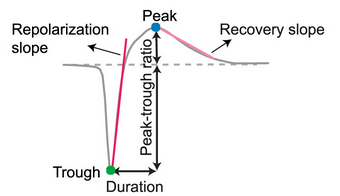

## Validation

The spiketoolkit package also provides several functions to compute qualitity metrics about the spike sorting results through the validation module

Some common errors that can be identified by quality metrics include

- Assigning spikes from multiple neurons to the same cluster
- Missing spikes from neurons with waveform amplitude near the spike detection threshold
- Failing to track neurons with waveforms that change as a result of electrode drift

List of available metrics, taken from the allen institute : https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html

- num_spikes

- firing_rate

- presence_ratios

- isi_violations

- amplitude cutoff

- nn_metrics

These additional metrics are added to the previous database with the postprocessing metrics

In [23]:

st.validation.get_quality_metrics_list()

def calculate_additional_metrics(recording_loaded,Sorters,Path_results):
    df = pd.read_excel(os.path.join(Path_results,'metrics_sorters.xlsx'))
    columns_names_to_add =  ["Id_key",'id_cluster',"num_spikes", "firing_rate", "presence_ratio", "isi_violation", "amplitude_cutoff", "snr","isolation_distance", "l_ratio", "nn_hit_rate", "nn_miss_rate"]
    df2=pd.DataFrame(columns = columns_names_to_add)
    i=0
    Metrics_per_sorter = list()
    for s in Sorters :
        metrics2 = st.validation.compute_quality_metrics(sorting=s, recording=recording_loaded, metric_names=["num_spikes", "firing_rate", "presence_ratio", "isi_violation", "amplitude_cutoff", "snr","isolation_distance", "l_ratio", "nn_hit_rate", "nn_miss_rate"], as_dataframe=True)
        name = [metrics2,Sorters_name[i]]
        print(Sorters_name[i])
        Metrics_per_sorter.append(name)
        metrics2['id_cluster']=metrics2.index
        metrics2 = metrics2.applymap(str)
        metrics2 = metrics2.assign(Sorter=Sorters_name[i])
        metrics2['Id_key'] = metrics2['id_cluster']+ metrics2['Sorter']
        df2 = df2.append(metrics2)
        i+=1
    df_allmetrics = pd.merge(df, df2, on="Id_key")
    df_allmetrics.to_excel(os.path.join(Path_results,'all_metrics_sorters.xlsx'), index = False)
    return df_allmetrics, Metrics_per_sorter

Path_results=r'F:\Data_recording\Lab_presentation\003WO.1_014_turning_different_speeds_g0_imec0\Sorting_results'
#df_allmetrics,Metrics_per_sorter = calculate_additional_metrics(recording_loaded=recording_loaded,Sorters=Sorters,Path_results=Path_results)
Path_all_metrics = os.path.join(Path_results,'all_metrics_sorters.xlsx')
df_allmetrics = pd.read_excel(Path_all_metrics, index_col=0)  
display(df_allmetrics)

,id_cluster_x,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope,Sorter_x,id_cluster_y,num_spikes,firing_rate,presence_ratio,isi_violation,amplitude_cutoff,snr,isolation_distance,l_ratio,nn_hit_rate,nn_miss_rate,Sorter_y
Id_key,,,,,,,,,,,,,,,,,,,
0sorting_KS2,0,0.000200,0.000167,-0.520885,39805.297196,-3324.921392,sorting_KS2,0,363,4.563628,0.88,0.203477,0.500000,4.665459,6.084337e+01,0.312786,0.615556,0.146759,sorting_KS2
1sorting_KS2,1,0.000267,0.000167,-0.337919,42862.550067,-878.471249,sorting_KS2,1,26,0.326871,0.21,0.000000,0.009953,5.373282,4.927850e+15,NaN,0.064103,0.010060,sorting_KS2
2sorting_KS2,2,0.000533,0.000267,-0.737666,29791.131687,-8422.449185,sorting_KS2,2,3,0.037716,0.03,0.000000,0.500000,7.018864,4.960940e+15,NaN,0.000000,0.003444,sorting_KS2
3sorting_KS2,3,0.000500,0.000233,-0.478837,28773.280002,-4741.281262,sorting_KS2,3,31,0.389731,0.27,0.000000,0.008348,5.811708,1.108823e+16,NaN,0.752688,0.006028,sorting_KS2
4sorting_KS2,4,0.000200,0.000133,-0.517179,108484.989849,-9299.022781,sorting_KS2,4,525,6.600288,0.90,0.000000,0.032371,11.037496,9.911094e+01,0.004101,0.984444,0.012037,sorting_KS2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19sorting_HS2,19,0.000567,0.000333,-1.005994,2721.634101,-1096.694551,sorting_HS2,19,635,7.983205,0.99,0.598443,0.047684,0.824404,NaN,NaN,1.000000,NaN,sorting_HS2
20sorting_HS2,20,0.000633,0.000200,-0.318821,32455.848374,-3966.528163,sorting_HS2,20,109,1.370345,0.53,0.000000,0.002374,8.386104,5.795291e+01,0.239810,0.501529,0.015302,sorting_HS2
21sorting_HS2,21,0.001000,0.000233,-0.133451,8677.524628,-484.217154,sorting_HS2,21,285,3.583013,0.94,0.330094,0.000908,4.131263,NaN,NaN,1.000000,NaN,sorting_HS2


## Curation - Quality metrics

The curation can be done by manual curation through Phy and/or automatic curation through the quality metrics and/or consensus based curation

For the purpose of this end to end example the results quality metrics of Kilosort2  will be calculated and plotted in order to obtain a dataframe containing the id clusters corresponding to the clusters to check manually on PHy since they crossed a given threshold, for example having a presence-ratio of less than 90% of the other units

After spike sorting and computing validation metrics, we can automatically curate the spike sorting output using the quality metrics. This can be done with the toolkit.curation submodule but we decided to use those quality metrics for enhanced manual curation for the moment and not for automatic curation.



In [ ]:

#Firing_rate plotting example
def plot_metric(data, bins, x_axis_label, color, max_value=-1):
    
    h, b = np.histogram(data, bins=bins, density=True)
    
    x = b[:-1]
    y = gaussian_filter1d(h, 1)
    plt.plot(x, y, color=color)
    plt.xlabel(x_axis_label)
    plt.gca().get_yaxis().set_visible(False)
    [plt.gca().spines[loc].set_visible(False) for loc in ['right', 'top', 'left']]
    if max_value < np.max(y) * 1.1:
        max_value = np.max(y) * 1.1
    plt.ylim([0, max_value])
    
    return max_value,h,b

Dataframe_KS_metrics = Metrics_per_sorter[0][0]

data_firingrate_KSresults = Dataframe_KS_metrics['firing_rate']
bins1 = np.linspace(0,50,100)
firing_rate_plot = plot_metric(data_firingrate_KSresults, bins1, 'Firing rate (Hz)', 'red')



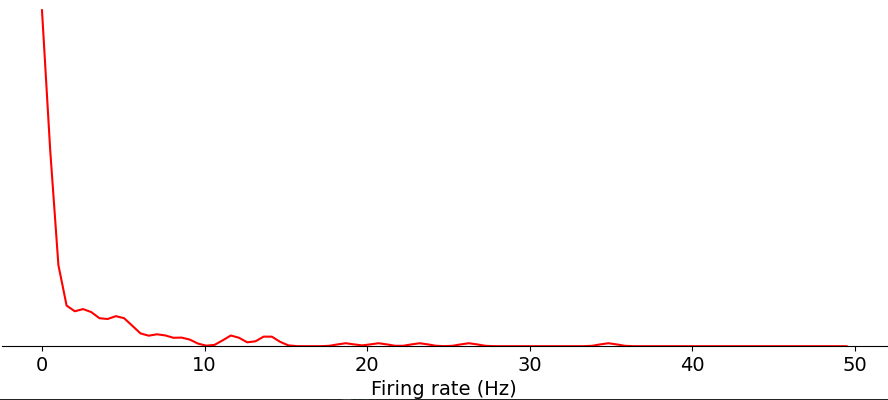

In [ ]:

#Since there are many units with low firing rates, let's use a log scale instead

data_firingrate_KSresults_log = np.log10(Dataframe_KS_metrics['firing_rate'])
bins2 = np.linspace(-3,2,100)
firing_rate_log, h, b = plot_metric(data_firingrate_KSresults_log, bins2, 'log$_{10}$ firing rate (Hz)', 'red')


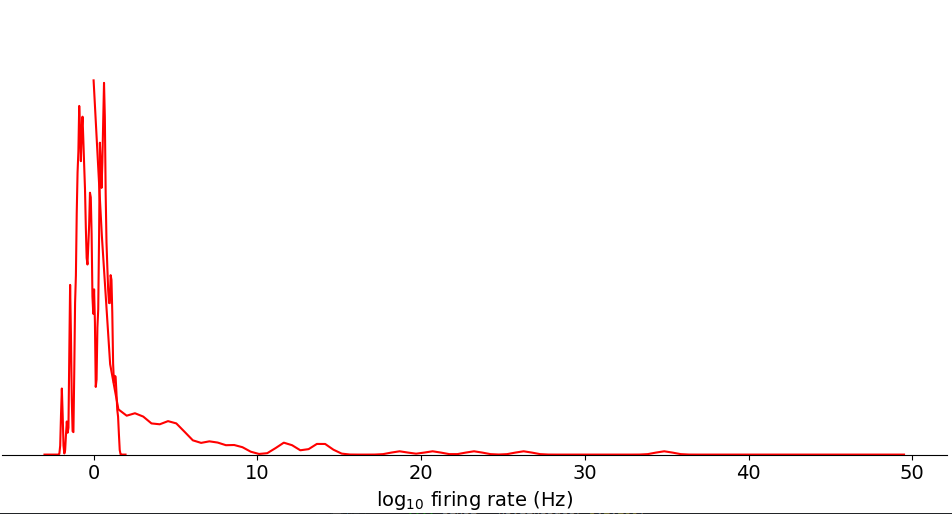

In [25]:


def table_clusters_to_analyze(Metrics_per_sorter):
    i=0
    Path = os.path.join(Path_results,'clusters_to_analyze_manually1.xlsx')
    for m in Metrics_per_sorter:
        Dataframe_KS_metrics = m[0]
        Metrics = ["firing_rate", "presence_ratio", "isi_violation", "amplitude_cutoff", "nn_hit_rate"]
        Columns = ['Id_cluster'] + Metrics
        df = pd.DataFrame(columns = Columns)
        df['Id_cluster']= Dataframe_KS_metrics.index
        df.set_index('Id_cluster',drop=False,inplace=True)
        firing_rate_threshold = np.percentile(Dataframe_KS_metrics['firing_rate'],90)
        #All the clusters having a firing_rate above the 9th percentile of the other clusters firing rate accross all the clusters will be highlighted
        presence_ratio_threshold = np.percentile(Dataframe_KS_metrics['presence_ratio'],50)
        #All the clusters having a presence_ratio less than the median presence ratio accross all the clusters will be highlighted
        isi_violation_threshold = 0.5
        #All the clusters having a  isi_violation higher than 0.5 will be highlighted for further analysis, 0.5 means that contamining spikes are occurring at roughly half the rate of "true" spikes for that unit. 
        amplitude_cutoff_threshold= 0.3
        #All the clusters having an amplitude cutoff higher than 0.3, meaning that 30% of the spikes are missing from the unit, it is the level of 'False negatives' and is completing the presence ratio analysis
        nn_hit_rate_threshold = 0.1
        #All the clusters having a nearest neighboor hit rate bigger than 10%, meaning that the fraction of their nearest neighbors that fall within the same cluster is higher than 10%
        Metrics=[["firing_rate",firing_rate_threshold],['presence_ratio',presence_ratio_threshold], ["isi_violation",isi_violation_threshold], ["amplitude_cutoff",amplitude_cutoff_threshold],  ["nn_hit_rate",nn_hit_rate_threshold]]
        #Thresholds = [firing_rate_threshold,presence_ratio_threshold,isi_violation_threshold,amplitude_cutoff_threshold,isolation_distance_threshold,nn_hit_rate_threshold]
        for i in Dataframe_KS_metrics.index:
            for m in Metrics :
                if m[0]=="presence_ratio":
                    if Dataframe_KS_metrics.loc[i][m[0]]< m[1]:
                        c = Dataframe_KS_metrics.loc[i][m[0]] 
                        df.at[[i],[m[0]]]=c
                else:
                    if Dataframe_KS_metrics.loc[i][m[0]] > m[1]:
                        c = Dataframe_KS_metrics.loc[i][m[0]] 
                        df.at[[i],[m[0]]]=c
        writer = pd.ExcelWriter(Path, engine = 'xlsxwriter')
        df.to_excel(writer, sheet_name = m[1])
        writer.save()
        writer.close()
        i+=1
    df = pd.read_excel(Path)
    return df

Path_clusters_analyze = r'F:\Data_recording\Lab_presentation\003WO.1_014_turning_different_speeds_g0_imec0\Sorting_results\clusters_to_analyze_manually.xlsx'
df_clusters_toanalyze = pd.read_excel(Path_clusters_analyze, index_col=0)

#The following table gives the ID clusters that need to be analyzed further manually in Phy since they are crossing the thresholds settled concerning the quality metrics
print(df_clusters_toanalyze)

            firing_rate  presence_ratio  isi_violation  amplitude_cutoff  \
Id_cluster                                                                 
0                   NaN             NaN            NaN          0.500000   
1                   NaN            0.21            NaN               NaN   
2                   NaN            0.03            NaN          0.500000   
3                   NaN            0.27            NaN               NaN   
4                   NaN             NaN            NaN               NaN   
...                 ...             ...            ...               ...   
141                 NaN             NaN            NaN               NaN   
142                 NaN             NaN            NaN          0.446159   
143                 NaN             NaN            NaN          0.500000   
144                 NaN             NaN       0.559977               NaN   
145                 NaN             NaN            NaN               NaN   

           

## Curation - Manual


We can now open the Phy view of the Kilosort2 results to start the manual aspect of the analysis based on the insights of the quality metrics.

The next step is then to go through this data and quickly verify that the sorting was efficient and coherent. 

In the Phy2 interface, we have access to all the data Kilosort2 was able to extract from the raw electrophysiological feed we provided it with, and we can manually check the treatment to fine tune the spike sorting.

To do so we integrate the insights obtained thanks to the table 'clusters to analyze' previously obtained by calculating the quality metrics.



Example of manual curation - Merging 

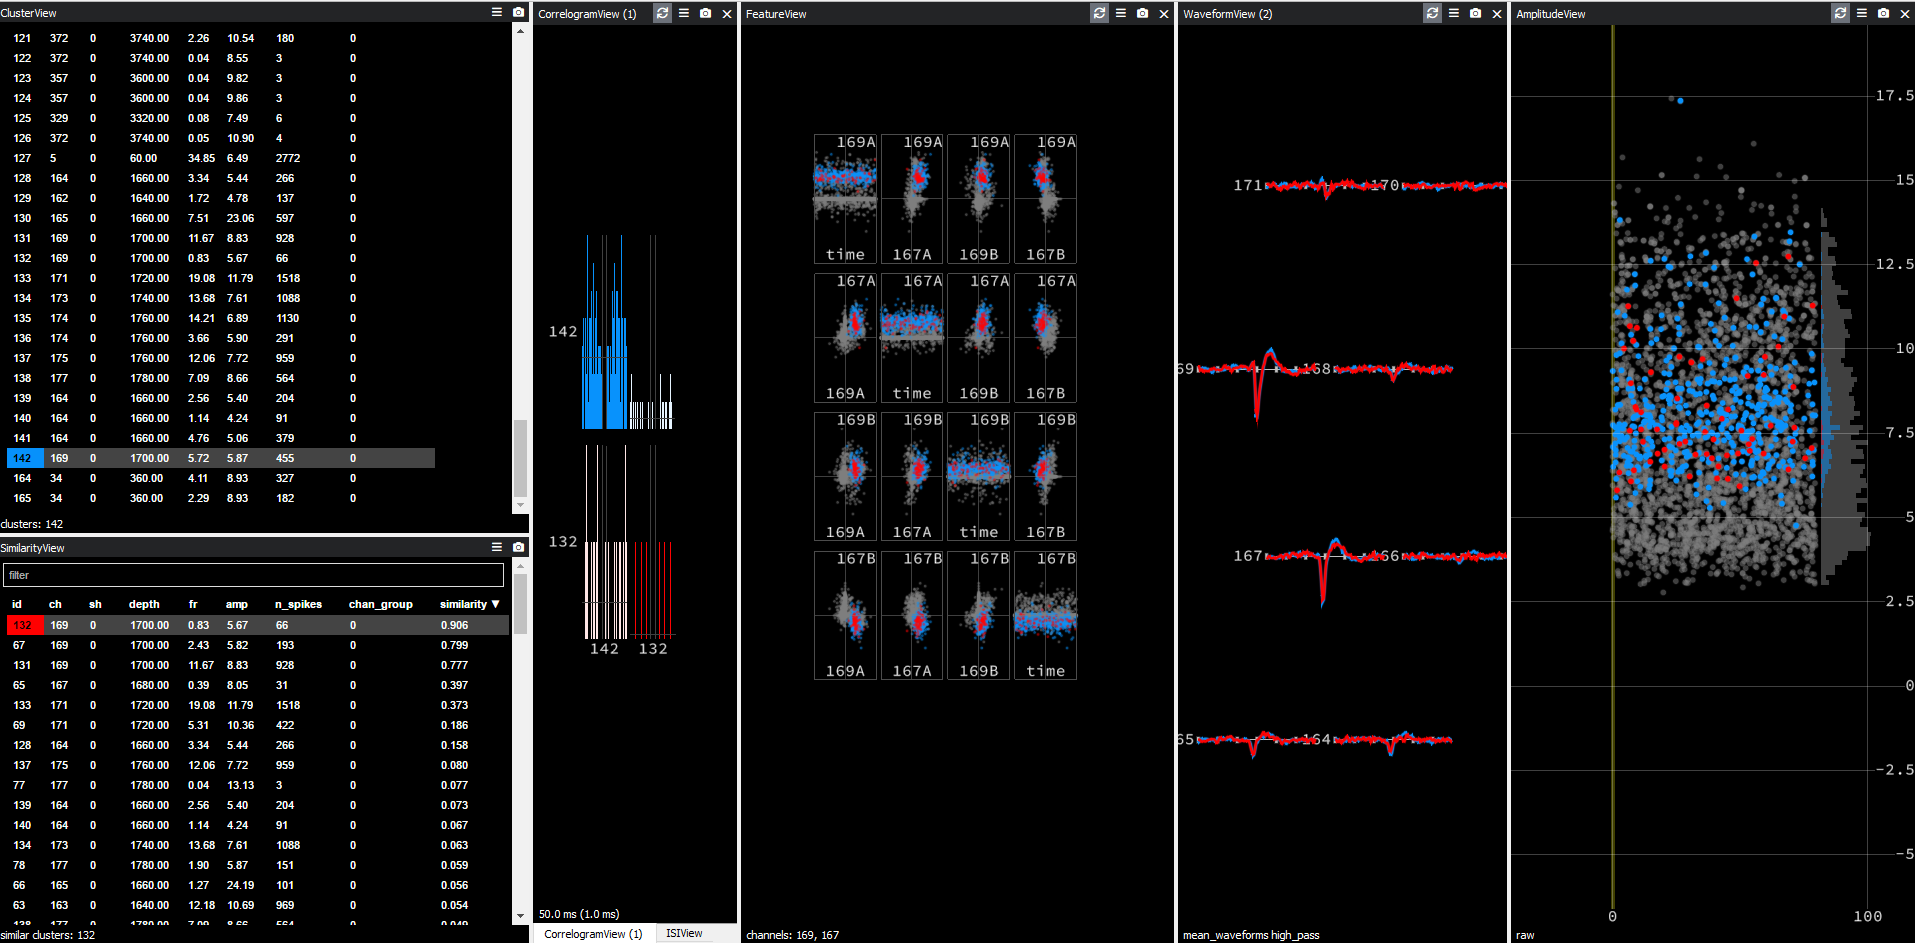

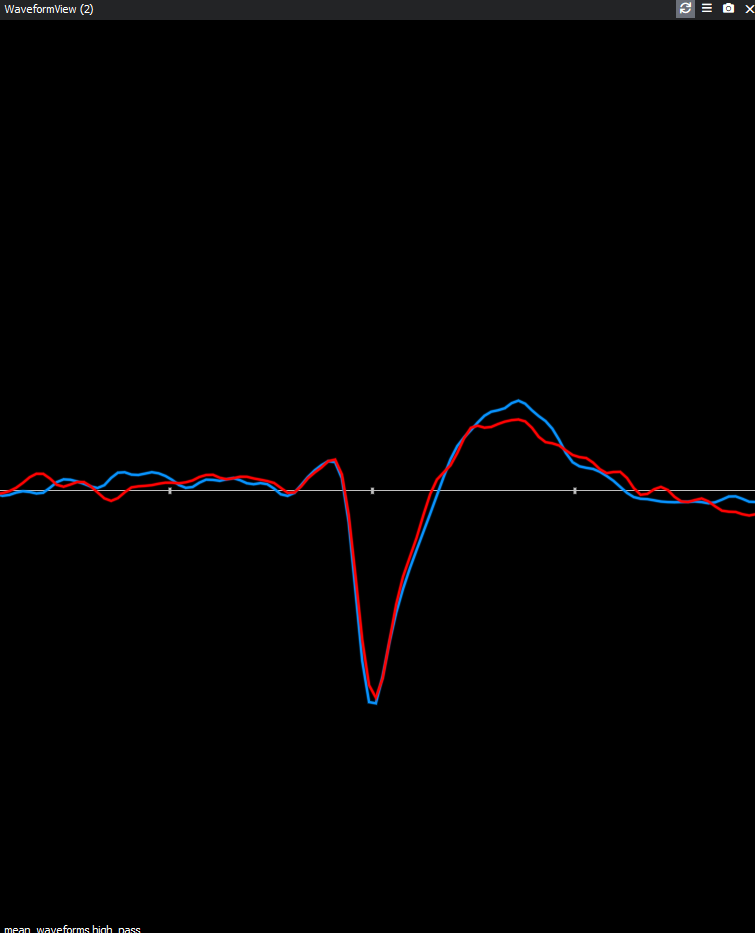

Example of manual curation - Splitting 

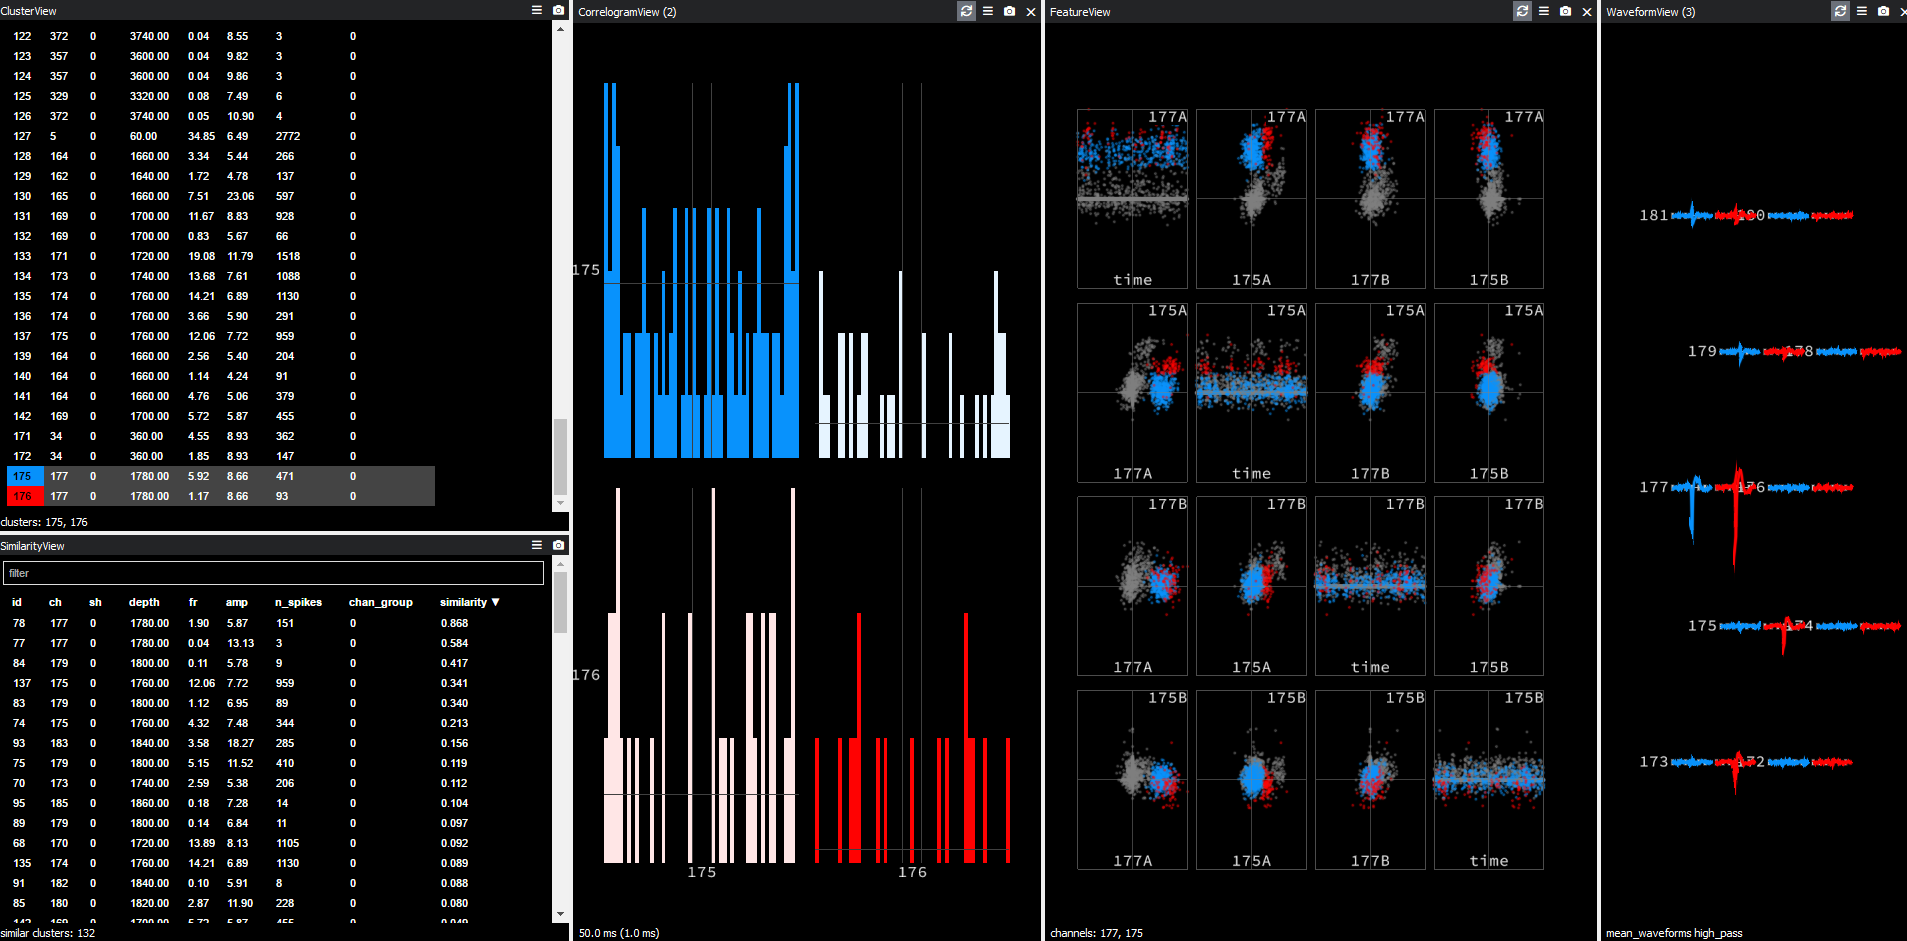

In [28]:


#Before the manual curation through Phy2 helped with the quality metrics table we had 145 units
print(len(sorting_KS2.get_unit_ids()))

#After curating the results we can reload it using the PhySortingExtractor, we exclude the cluster groups corresponding to noise
Phy_path = r'F:\Data_recording\Lab_presentation\003WO.1_014_turning_different_speeds_g0_imec0\Sorting_results\_KS2_results'
sorting_KS_phy_curated = se.PhySortingExtractor(Phy_path)

#After curation only 19 units are left
print(len(sorting_KS_phy_curated.get_unit_ids()))

143
71


## Curation - Consensus based


We can now do the last type of curation which is the agreement sorting based on our half-automatic curation of the Kilosort2 results and the results of Tridesclous along with Ironclust and Herding spikes. 

We can use the comparison module. We first compare and match the output spike trains of the different sorters, and we can then extract a new SortingExtractor with only the units in agreement.

When extracting the units in agreement, the spike trains are modified so that only the true positive spikes between the comparison with the best match are used.


In [30]:

mcmp = sc.compare_multiple_sorters(sorting_list=Sorters, name_list=['KS2', 'TDC','IC','HS2'], delta_time=0.4, match_score=0.5, chance_score=0.1,
                             n_jobs=-1, spiketrain_mode='intersection', sampling_frequency=None, verbose=False)

#The total number of units for which k sorters agree (unit agreement is defined as 50% spike match).
w = sw.plot_multicomp_agreement(mcmp)
#The number of units (per sorter) for which k sorters agree; most sorters find many units that other sorters do not.
w = sw.plot_multicomp_agreement_by_sorter(mcmp)


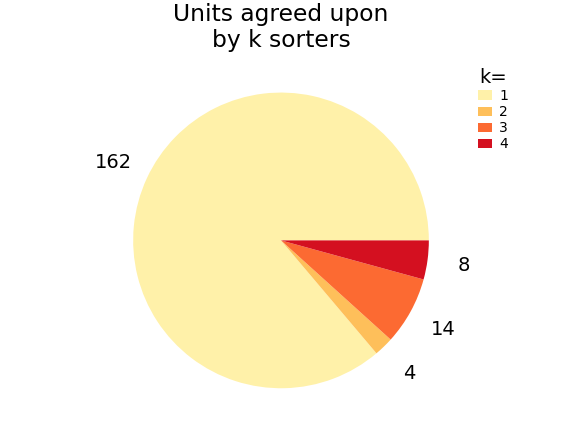


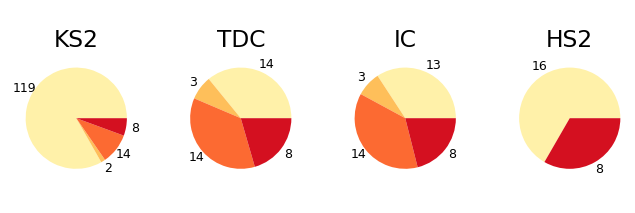



In [31]:
#26 units are agreed upon by at leat 2 sorters

agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)
isinstance(agreement_sorting, se.SortingExtractor)
print(len(agreement_sorting.get_unit_ids()))

26


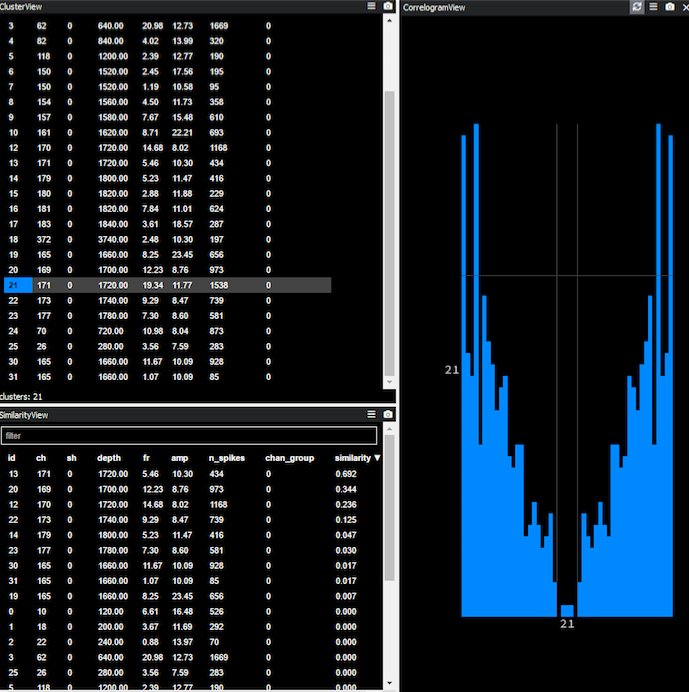

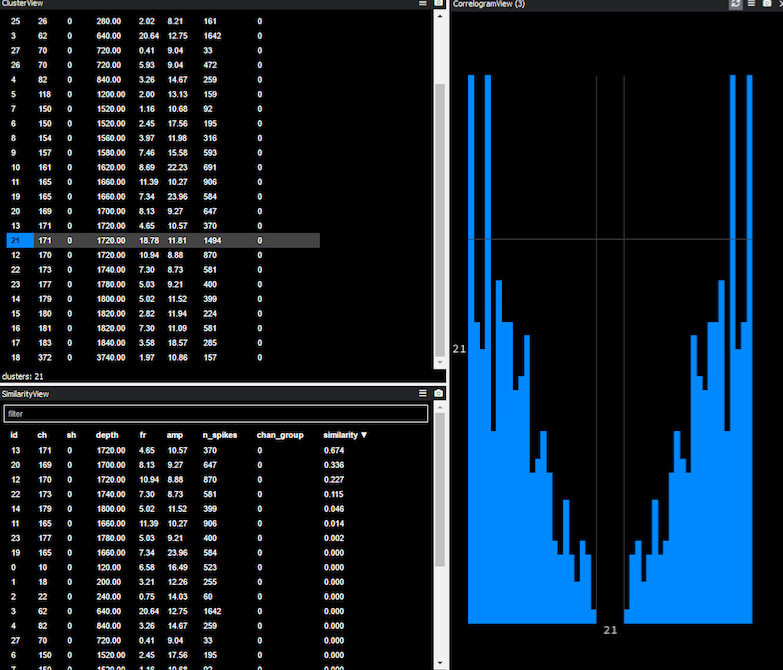

In [ ]:
#Exporting the agreement sorting to Phy

Phy_agreement_folder = r'F:\Data_recording\Lab_presentation\003WO.1_014_turning_different_speeds_g0_imec0\Sorting_results\Phy-agr2'
st.postprocessing.export_to_phy(recording_loaded, 
                                agreement_sorting, output_folder=Phy_agreement_folder,verbose=True, recompute_info=True, max_channels_per_template=10)



The agreement sorting was very clean and it took only 5 minutes to get rid of the remaining noise. It is important to notice that 13 of the clusters found by agreement sorting are at the depth of the presubiculum.

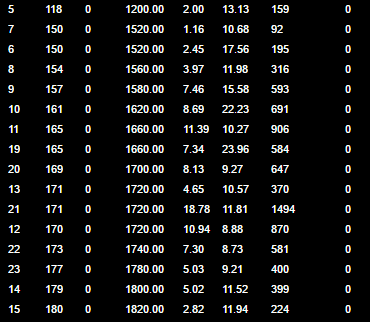


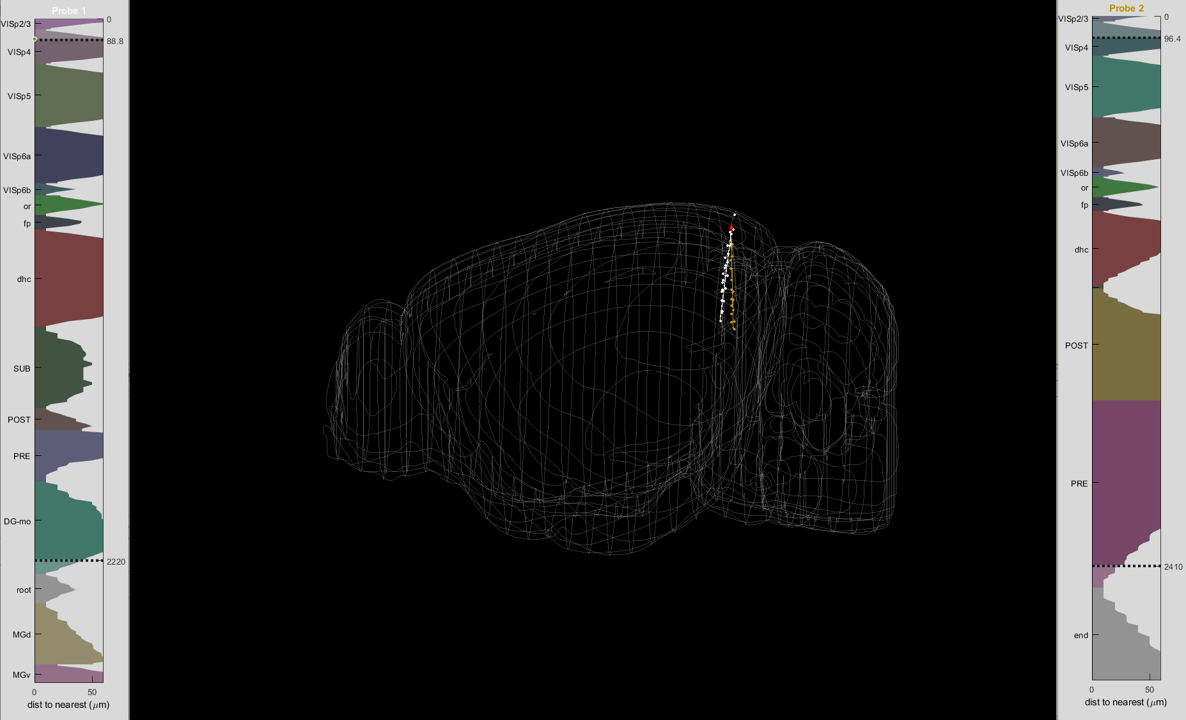

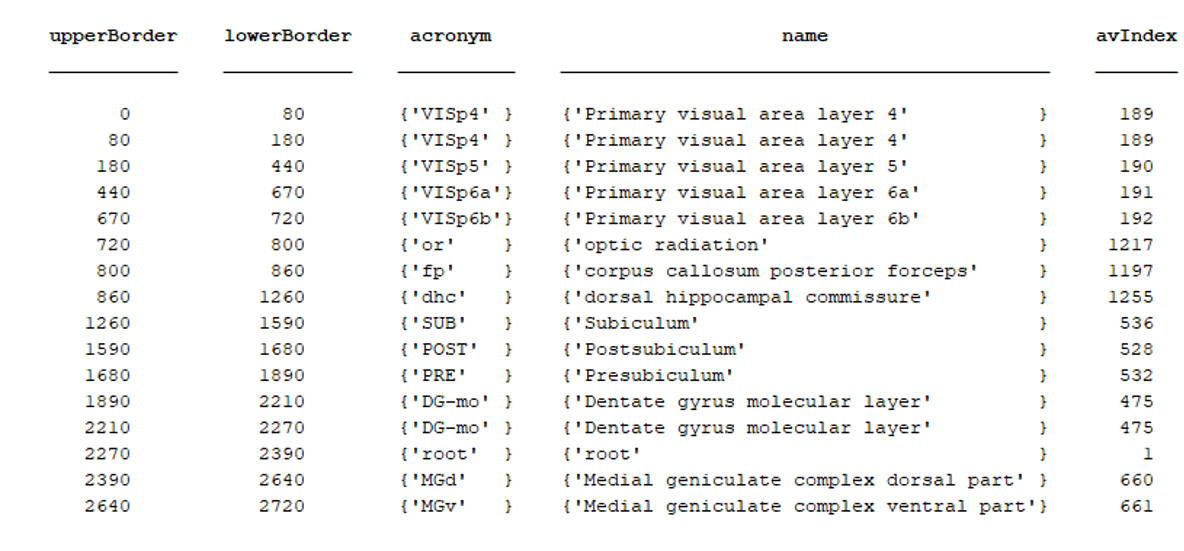

The combination of automatic sorting by parametring the 4 sorters,the quality metrics analysis,the manual curation and the agreement sorting lead us to find 22 good units. These results will be further analyzed to fine tune the recorded traces of these units with the neurons they correspond in order to realize population analysis and burst firing neurons of layer IV identification.